In [1]:
#!ipcluster start -n 8 --engines=MPI --profile='mpi' # for parallel run: start the engines using terminal
from ipyparallel import Client
rc = Client(profile='mpi64')

In [2]:
%%px
# Import the libraries

import os
import sys
import math
import pyJHTDB
import numpy as np
import pyfftw as ft 
from mpi4py import MPI
from pyJHTDB import libJHTDB
from pyJHTDB.dbinfo import isotropic1024coarse

from mpiFFT4py.slab import R2C

In [3]:
%%px

Nx = isotropic1024coarse['nx']; Ny = isotropic1024coarse['ny']; Nz = isotropic1024coarse['nz']
Lx = isotropic1024coarse['lx']; Ly = isotropic1024coarse['ly']; Lz = isotropic1024coarse['lz']

######################################

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
nproc = comm.Get_size()
if(rank==0):
    print("n_proc = "+str(nproc))
    print("rank = "+str(rank))

[stdout:18] 
n_proc = 64
rank = 0


In [4]:
%%px

######################################
#      Computational Domain          #
######################################

nx=Nx//nproc; ny=Ny; nz=Nz
time = 0.0

########## FFT alocation #############

N = np.array([Nx,Ny,Nz],dtype=int)
L = np.array([Lx,Ly,Lz],dtype=float)

FFT = R2C(N, L, MPI.COMM_WORLD, "double", communication='Alltoallw')

######### Vector alocation ###########

In [5]:
%%px

if rank==0:
    print(FFT.real_shape())

[stdout:18] (16, 1024, 1024)


In [6]:
%%px

######### Vector alocation ###########

dx = isotropic1024coarse['dx']

comm.Barrier(); t1=MPI.Wtime()

X = np.zeros(FFT.real_shape(), dtype=FFT.float)
Y = np.zeros(FFT.real_shape(), dtype=FFT.float)
Z = np.zeros(FFT.real_shape(), dtype=FFT.float)

r2 = np.zeros(FFT.real_shape(), dtype=FFT.float)

chi = np.zeros(FFT.real_shape(), dtype=FFT.float)
cchi = np.zeros(FFT.complex_shape(), dtype=FFT.complex)
corr = np.zeros(FFT.real_shape(), dtype=FFT.float)
iCorr = np.zeros(FFT.real_shape(), dtype=FFT.float)

r2Sum = np.zeros(FFT.real_shape(), dtype=FFT.float)
r2F = np.zeros(FFT.real_shape(), dtype=FFT.float)

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Alocating vectors: {0:.2f} seconds\n'.format(t2-t1))

[stdout:18] Alocating vectors: 0.04 seconds


In [8]:
%%px

####### Spatial Information #########

comm.Barrier(); t1=MPI.Wtime()
for i in range(nx):
    if (i+nx*rank)<Nx//2:
        X[i,:,:] = (i+nx*rank)*isotropic1024coarse['dx']
    else:
        X[i,:,:] = isotropic1024coarse['lx']-(i+nx*rank)*isotropic1024coarse['dx']
    
for j in range(ny):
    if j<Ny//2:
        Y[:,j,:] = j*isotropic1024coarse['dy']
    else:
        Y[:,j,:] = isotropic1024coarse['ly']-j*isotropic1024coarse['dy']
    
for k in range(nz):
    if k<Nz//2:
        Z[:,:,k] = k*isotropic1024coarse['dz']
    else:
        Z[:,:,k] = isotropic1024coarse['lz']-k*isotropic1024coarse['dz']
    
r2[:,:,:] = X[:,:,:]**2+Y[:,:,:]**2+Z[:,:,:]**2

r2rt = np.sqrt(r2)
del r2

######## Domain boundaries ##########

minrt = r2rt.min()
maxrt = r2rt.max()

minr2Gl=np.zeros(nproc,dtype=FFT.float)
maxr2Gl=np.zeros(nproc,dtype=FFT.float)

comm.Allgather([minrt,MPI.DOUBLE],[minr2Gl,MPI.DOUBLE])
comm.Allgather([maxrt,MPI.DOUBLE],[maxr2Gl,MPI.DOUBLE])

minrt = minr2Gl.min()
maxrt = maxr2Gl.max()

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Preparing the real domain for radial integration: {0:.2f} seconds\n'.format(t2-t1))

ner = int((maxrt-minrt)/isotropic1024coarse['dx'])

rbins = np.linspace(minrt,maxrt,ner+1)

[stdout:18] Preparing the real domain for radial integration: 5.07 seconds


In [15]:
%%px

del X,Y,Z

In [1]:
%%px

###################################
######## Reading Data #############
###################################

folder = '/home/jhelsas/scratch/slab64'

##########

filename = 'ref-Q-'+str(rank)+'.npz'
file = folder + "/" + filename

comm.Barrier(); t1=MPI.Wtime()
content = np.load(file)
    
Q = np.zeros(FFT.real_shape(), dtype=FFT.float)
Q[:,:,:] = content['Q'].astype(FFT.float)
    
comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    print("Finished loading")
    sys.stdout.write('Load from disk: {0:.2f} seconds\n'.format(t2-t1))

ERROR:root:Cell magic `%%px` not found.


In [11]:
%%px

filename = 'ref-R-'+str(rank)+'.npz'
file = folder + "/" + filename

comm.Barrier(); t1=MPI.Wtime()
content = np.load(file)
    
R = np.zeros(FFT.real_shape(), dtype=FFT.float)
R[:,:,:] = content['R'].astype(FFT.float)
    
comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    print("Finished loading")
    sys.stdout.write('Load from disk: {0:.2f} seconds\n'.format(t2-t1))

#########

[stdout:18] 
Finished loading
Load from disk: 0.98 seconds


In [12]:
%%px

filename = 'ref-strainrate-'+str(rank)+'.npz'
file = folder + "/" + filename

comm.Barrier(); t1=MPI.Wtime()
content = np.load(file)
    
S2 = np.zeros(FFT.real_shape(), dtype=FFT.float)
    
S2[:,:,:] = content['S2'].astype(FFT.float)
    
comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    print("Finished loading")
    sys.stdout.write('Load from disk: {0:.2f} seconds\n'.format(t2-t1))

[stdout:18] 
Finished loading
Load from disk: 1.02 seconds


In [13]:
%%px

#######################################
##### Finding field parameters ########
#######################################

avgE = np.average(S2)
avgEGl=np.zeros(1,dtype=FFT.float)
comm.Allreduce([avgE,MPI.DOUBLE],[avgEGl,MPI.DOUBLE],op=MPI.SUM)
avgE = avgEGl[0]/nproc
if rank == 0:
    print(avgE)
    
avg = avgE

#################################################

minS2 = S2.min(); maxS2 = S2.max()

minS2Gl=np.zeros(nproc,dtype=FFT.float)
maxS2Gl=np.zeros(nproc,dtype=FFT.float)

comm.Allgather([minS2,MPI.DOUBLE],[minS2Gl,MPI.DOUBLE])
comm.Allgather([maxS2,MPI.DOUBLE],[maxS2Gl,MPI.DOUBLE])

minE = minS2Gl.min(); maxE = maxS2Gl.max()

################################################
######### Finding min and max Q/R ##############
################################################

comm.Barrier()
    
R = R/avg
Q = Q/(avg**(1.5))
    
##################################

minQ = Q.min(); maxQ = Q.max()

minQGl=np.zeros(nproc,dtype=FFT.float)
maxQGl=np.zeros(nproc,dtype=FFT.float)

comm.Allgather([minQ,MPI.DOUBLE],[minQGl,MPI.DOUBLE])
comm.Allgather([maxQ,MPI.DOUBLE],[maxQGl,MPI.DOUBLE])

minQ = minQGl.min(); maxQ = maxQGl.max()

##################################

minR = R.min(); maxR = R.max()

minRGl=np.zeros(nproc,dtype=FFT.float)
maxRGl=np.zeros(nproc,dtype=FFT.float)

comm.Allgather([minR,MPI.DOUBLE],[minRGl,MPI.DOUBLE])
comm.Allgather([maxR,MPI.DOUBLE],[maxRGl,MPI.DOUBLE])

minR = minRGl.min(); maxR = maxRGl.max()

comm.Barrier()

[stdout:18] 249.217673008


In [14]:
%%px

if rank==0:
    print(minQ,maxQ,minR,maxR)

[stdout:18] (-5.8377248773933337, 19.36055461542681, -7512.2045014011128, 7129.4427219148411)


In [53]:
%%px

Ngrid=960;rmin=-60.0;rmax=60.0;qmin=-60.0;qmax=60.0
xedges=np.linspace(rmin,rmax,Ngrid+1,endpoint=True); 
dx=xedges[1]-xedges[0]
yedges=np.linspace(qmin,qmax,Ngrid+1,endpoint=True); 
dy=yedges[1]-yedges[0]

In [15]:
%%px

def FindJointPDF(x,y,lowerLim_x,upperLim_x,lowerLim_y,upperLim_y,bins_x,bins_y):
    x=x.flatten()
    y=y.flatten()
    totL=len(x)
    xedges=np.linspace(lowerLim_x,upperLim_x,bins_x+1,endpoint=True); dx=xedges[1]-xedges[0]
    yedges=np.linspace(lowerLim_y,upperLim_y,bins_y+1,endpoint=True); dy=yedges[1]-yedges[0]
    jPDF,xedges,yedges=np.histogram2d(x,y,bins=(xedges,yedges))
    jPDF=jPDF/(dx*dy*totL)
    gridX,gridY=np.meshgrid(xedges[0:-1]+0.5*dx,yedges[0:-1]+0.5*dy)
    return jPDF.T,gridX,gridY

In [16]:
%%px

q=Q.flatten()
r=R.flatten()

In [37]:
%%px

Ngrid=960;rmin=-60.0;rmax=60.0;qmin=-60.0;qmax=60.0 # Constants for jPDF
jPDF,gridX,gridY=FindJointPDF(r,q,rmin,rmax,qmin,qmax,Ngrid,Ngrid)

In [38]:
%%px

gPDF = np.zeros(jPDF.shape,dtype='float32')
jPDF = jPDF.astype(dtype='float32')

if rank==0:
    print(jPDF.shape,jPDF.dtype)
    print(gPDF.shape,gPDF.dtype)

[stdout:18] 
((960, 960), dtype('float32'))
((960, 960), dtype('float32'))


In [40]:
%%px

print(jPDF[jPDF>0.])

[stdout:0] 
[  3.81469727e-06   3.81469727e-06   3.81469727e-06 ...,   3.81469727e-06
   3.81469727e-06   3.81469727e-06]
[stdout:1] 
[  3.81469727e-06   3.81469727e-06   3.81469727e-06 ...,   3.81469727e-06
   3.81469727e-06   3.81469727e-06]
[stdout:2] 
[  3.81469727e-06   3.81469727e-06   3.81469727e-06 ...,   3.81469727e-06
   3.81469727e-06   3.81469727e-06]
[stdout:3] 
[  3.81469727e-06   3.81469727e-06   3.81469727e-06 ...,   3.81469727e-06
   3.81469727e-06   3.81469727e-06]
[stdout:4] 
[  3.81469727e-06   3.81469727e-06   3.81469727e-06 ...,   3.81469727e-06
   3.81469727e-06   3.81469727e-06]
[stdout:5] 
[  3.81469727e-06   3.81469727e-06   3.81469727e-06 ...,   3.81469727e-06
   3.81469727e-06   3.81469727e-06]
[stdout:6] 
[  3.81469727e-06   3.81469727e-06   3.81469727e-06 ...,   3.81469727e-06
   3.81469727e-06   3.81469727e-06]
[stdout:7] 
[  3.81469727e-06   7.62939453e-06   3.81469727e-06 ...,   3.81469727e-06
   3.81469727e-06   3.81469727e-06]
[stdout:8] 
[  3.8146972

In [35]:
%%px 

comm.Allreduce([jPDF,MPI.REAL],[gPDF,MPI.REAL],op=MPI.SUM)

In [36]:
%%px

print(gPDF[gPDF>0.])

[stdout:0] 
[  3.81469727e-06   3.81469727e-06   6.86645508e-05 ...,   7.62939453e-06
   3.81469727e-06   3.81469727e-06]
[stdout:1] 
[  3.81469727e-06   3.81469727e-06   6.86645508e-05 ...,   7.62939453e-06
   3.81469727e-06   3.81469727e-06]
[stdout:2] 
[  3.81469727e-06   3.81469727e-06   6.86645508e-05 ...,   7.62939453e-06
   3.81469727e-06   3.81469727e-06]
[stdout:3] 
[  3.81469727e-06   3.81469727e-06   6.86645508e-05 ...,   7.62939453e-06
   3.81469727e-06   3.81469727e-06]
[stdout:4] 
[  3.81469727e-06   3.81469727e-06   6.86645508e-05 ...,   7.62939453e-06
   3.81469727e-06   3.81469727e-06]
[stdout:5] 
[  3.81469727e-06   3.81469727e-06   6.86645508e-05 ...,   7.62939453e-06
   3.81469727e-06   3.81469727e-06]
[stdout:6] 
[  3.81469727e-06   3.81469727e-06   6.86645508e-05 ...,   7.62939453e-06
   3.81469727e-06   3.81469727e-06]
[stdout:7] 
[  3.81469727e-06   3.81469727e-06   6.86645508e-05 ...,   7.62939453e-06
   3.81469727e-06   3.81469727e-06]
[stdout:8] 
[  3.8146972

In [ ]:
%%px

jPDF=gPDF/nproc

[stderr:18] /home/jhelsas/anaconda2/lib/python2.7/site-packages/ipyparallel/engine/__main__.py:18: RuntimeWarning: divide by zero encountered in log10


[output:18]

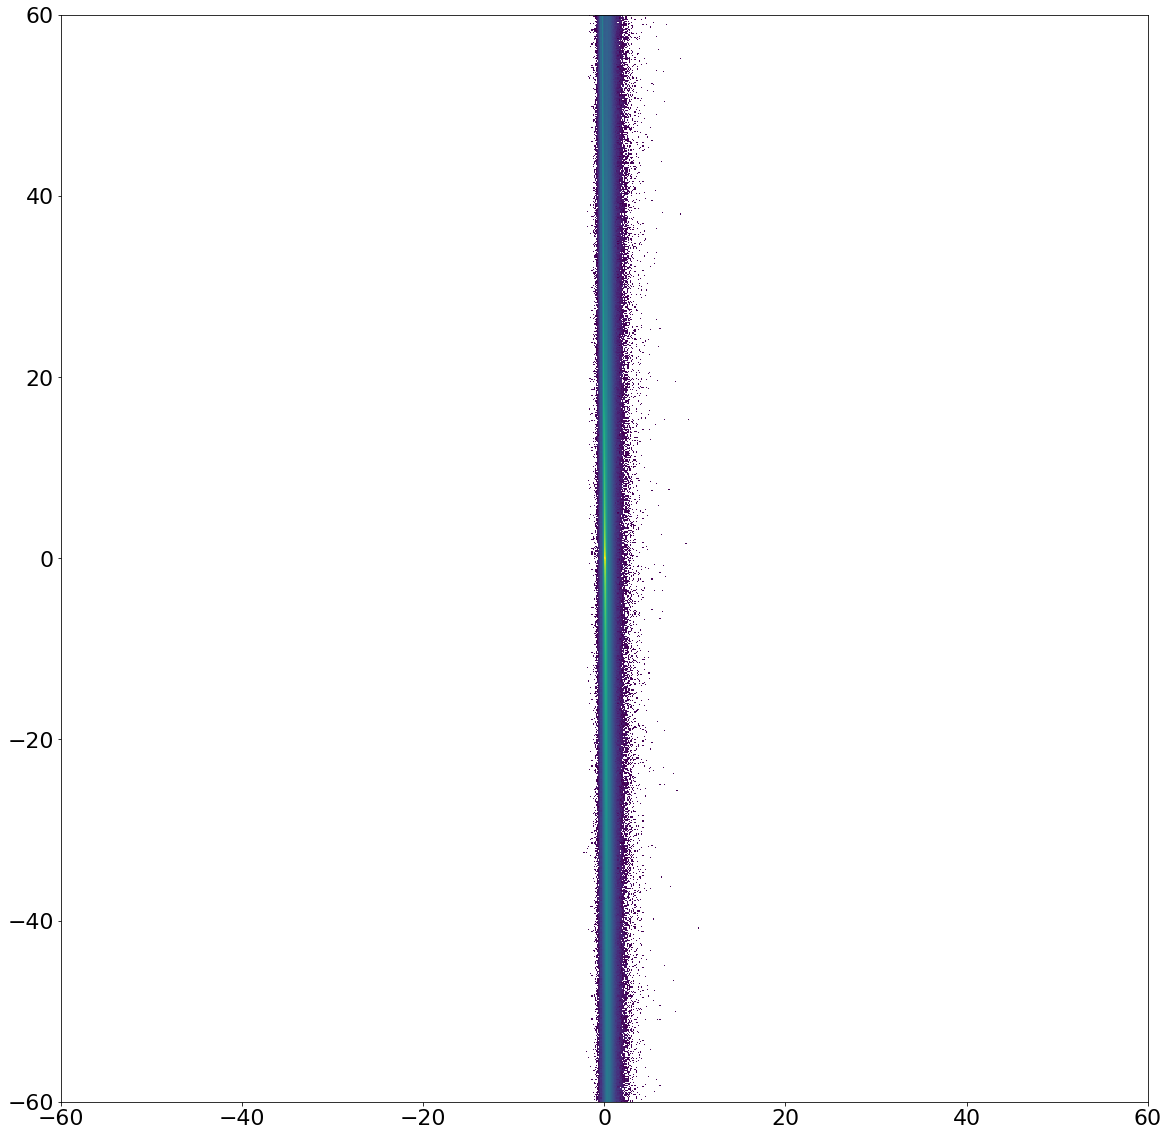

In [28]:
%%px

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

if rank==0:
    fmt={}
    fig = plt.figure(figsize=(20,20))
    SIZE=20
    plt.rc('font', size=SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=SIZE+4)  # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE+8)  # fontsize of the x any y labels
    plt.rc('xtick', labelsize=SIZE+2)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE+2)  # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE)  # legend fontsize

    logjPDF = np.log10(jPDF)
    cax = plt.imshow(logjPDF,interpolation='none',extent=(rmin,rmax,qmin,qmax),origin='lower', aspect='equal')

In [2]:
%%px

comm.Barrier(); t1=MPI.Wtime()

minJ = -0.5; maxJ =  0.5; E_bins = 5
tl = np.linspace(minJ,maxJ,num=E_bins,endpoint=True) 

if rank == 0:
    print("Q and R min/max : ",minQ,maxQ,minR,maxR)

##################################

if rank==0:
    print("Computation Boundaries : ",minJ,maxJ)
    print(tl)
    
lcorr = []; llogr = []; volFr = []

threshold = ((10.0)**3)/((1024.0)**3)

######################################

ERROR:root:Cell magic `%%px` not found.


In [32]:
%%px

comm.Barrier(); t1=MPI.Wtime()

for i in range(E_bins-1):
    comm.Barrier(); istart=MPI.Wtime()
    if(rank==0):
        print("Line - "+str(i))
    
    for j in range(E_bins-1):
        comm.Barrier(); jstart=MPI.Wtime()
                
        tQm = tl[i]; tQM = tl[i+1]; tRm = tl[j]; tRM = tl[j+1]
        Index = (Q>tQm)&(Q<tQM)&(R>tRm)&(R<tRM)
        
        chi[:,:,:] = 0
        chi[Index] = 1
        
        vf = np.average(chi)
        vgl = np.zeros(1,dtype=FFT.float)
        comm.Allreduce([vf,MPI.DOUBLE],[vgl,MPI.DOUBLE],op=MPI.SUM)
        vf = vgl/nproc
                    
        if vf>threshold:
            cchi = FFT.fftn(chi,cchi)
            tmp = cchi*(cchi.conj())
            corr = FFT.ifftn(tmp,corr)
            corr[:,:,:] = corr[:,:,:]/(Nx*Ny*Nz)
                        
            corrLoc,redges = np.histogram(r2rt,bins = rbins,weights=corr)
            r2Loc,r2edges = np.histogram(r2rt,bins = rbins)
            
            corrSum = np.zeros(corrLoc.shape,dtype=corrLoc.dtype)
            comm.Allreduce([corrLoc,MPI.DOUBLE],[corrSum,MPI.DOUBLE],op=MPI.SUM)
            r2Sum = np.zeros(r2Loc.shape,dtype=r2Loc.dtype)
            comm.Allreduce([r2Loc,MPI.DOUBLE],[r2Sum,MPI.DOUBLE],op=MPI.SUM)
        else:
            corrSum = np.zeros(rbins.shape)
            r2Loc = np.ones(rbins.shape)
                        
        if rank==0:
            volFr.append(vf)
            llogr.append(r2Sum)
            lcorr.append(corrSum)
        
        comm.Barrier(); jend=MPI.Wtime()
        if rank==0:
            print("time for iteration: "+str(jend-jstart))
        
    comm.Barrier(); iend=MPI.Wtime()    
    if rank==0:
        print("time to process line: "+str(iend-istart))

comm.Barrier(); t2=MPI.Wtime()

if rank==0:
    print("Total computing time: "+str(t2-t1))

[stdout:3] 
Line - 0
time for iteration: 31.2398879528
time for iteration: 13.7599852085
time for iteration: 15.1910600662
time for iteration: 13.5699679852
time to process line: 73.840873003
Line - 1
time for iteration: 13.0500049591
time for iteration: 14.6303019524
time for iteration: 12.6607558727
time for iteration: 14.0099380016
time to process line: 54.4201889038
Line - 2
time for iteration: 13.2408030033
time for iteration: 13.1094410419
time for iteration: 12.9201929569
time for iteration: 15.1697568893
time to process line: 54.4797611237
Line - 3
time for iteration: 13.1300470829
time for iteration: 14.4399969578
time for iteration: 13.1999640465
time for iteration: 14.6202759743
time to process line: 55.4403059483
Total computing time: 238.256248951


[stdout:3] 
t = (-0.3750000,-0.3750000)*sigma_2: Linear fit [alpha A] = 2.047
t = (-0.3750000,-0.1250000)*sigma_2: Linear fit [alpha A] = 2.048
t = (-0.3750000,0.1250000)*sigma_2: Linear fit [alpha A] = 2.022
t = (-0.3750000,0.3750000)*sigma_2: Linear fit [alpha A] = 2.093
t = (-0.1250000,-0.3750000)*sigma_2: Linear fit [alpha A] = 2.976
t = (-0.1250000,-0.1250000)*sigma_2: Linear fit [alpha A] = 2.953
t = (-0.1250000,0.1250000)*sigma_2: Linear fit [alpha A] = 2.912
t = (-0.1250000,0.3750000)*sigma_2: Linear fit [alpha A] = 2.983
t = (0.1250000,-0.3750000)*sigma_2: Linear fit [alpha A] = 2.965
t = (0.1250000,-0.1250000)*sigma_2: Linear fit [alpha A] = 2.874
t = (0.1250000,0.1250000)*sigma_2: Linear fit [alpha A] = 2.918
t = (0.1250000,0.3750000)*sigma_2: Linear fit [alpha A] = 2.978
t = (0.3750000,-0.3750000)*sigma_2: Linear fit [alpha A] = 2.735
t = (0.3750000,-0.1250000)*sigma_2: Linear fit [alpha A] = 2.740
t = (0.3750000,0.1250000)*sigma_2: Linear fit [alpha A] = 2.732
t = (0.37500

[output:3]

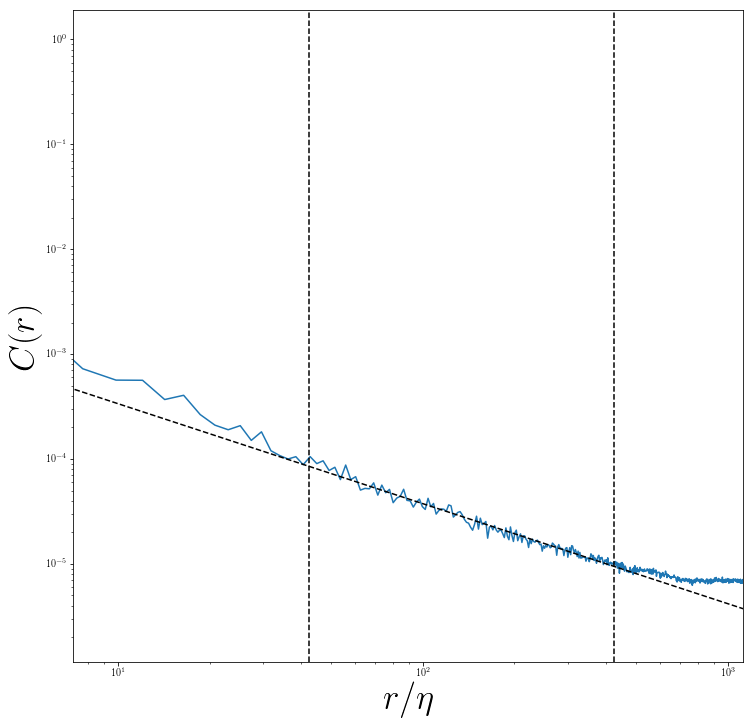

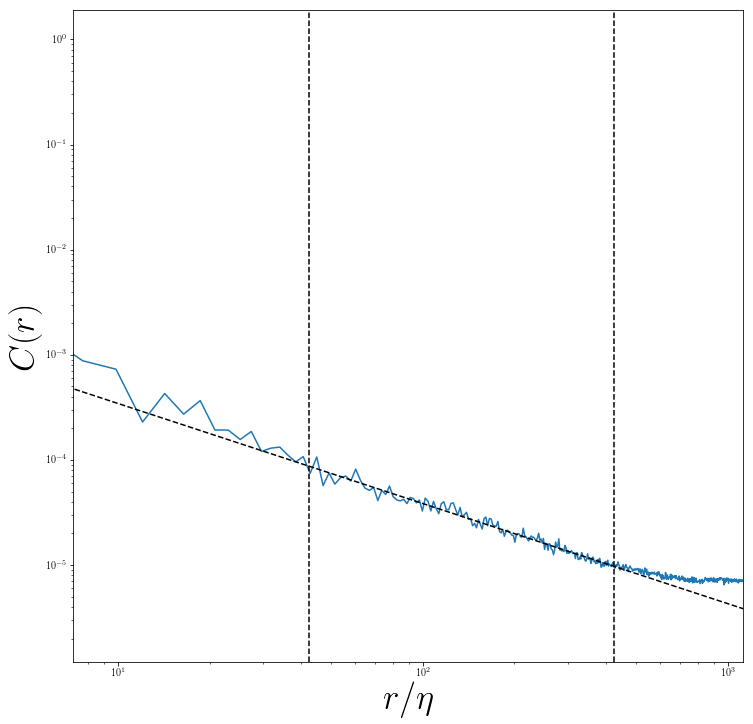

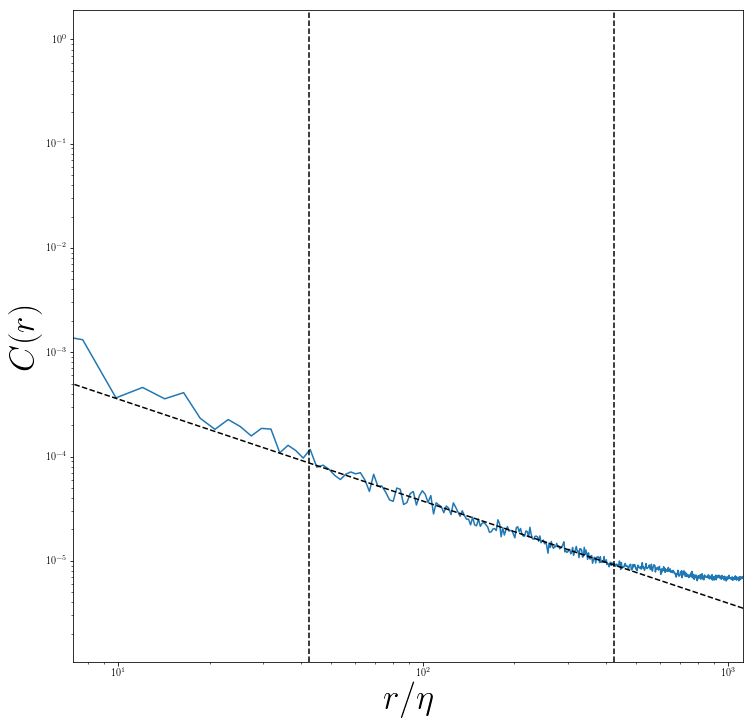

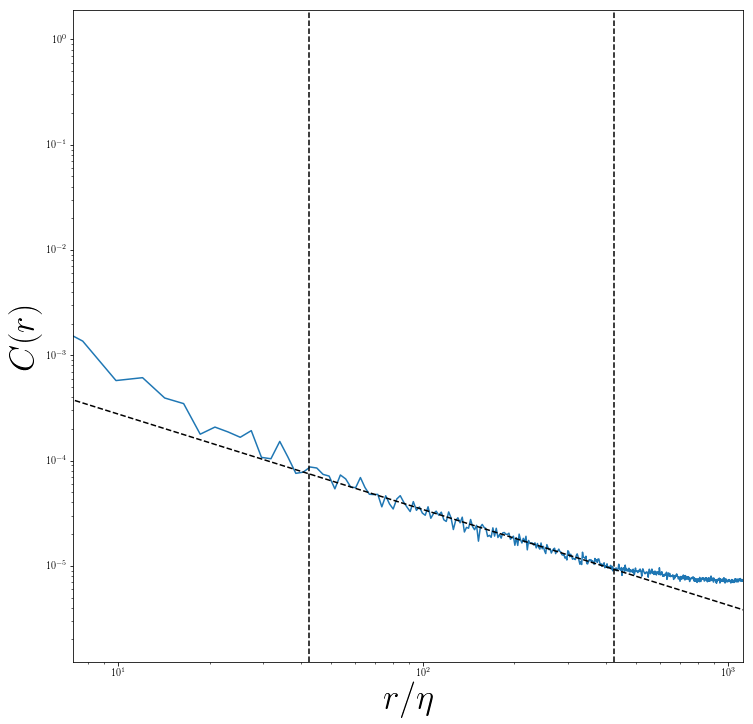

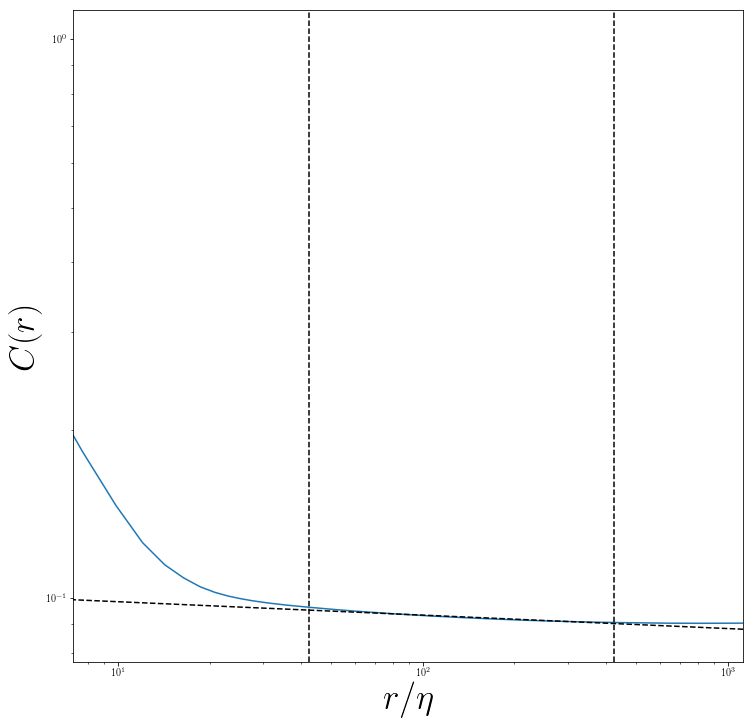

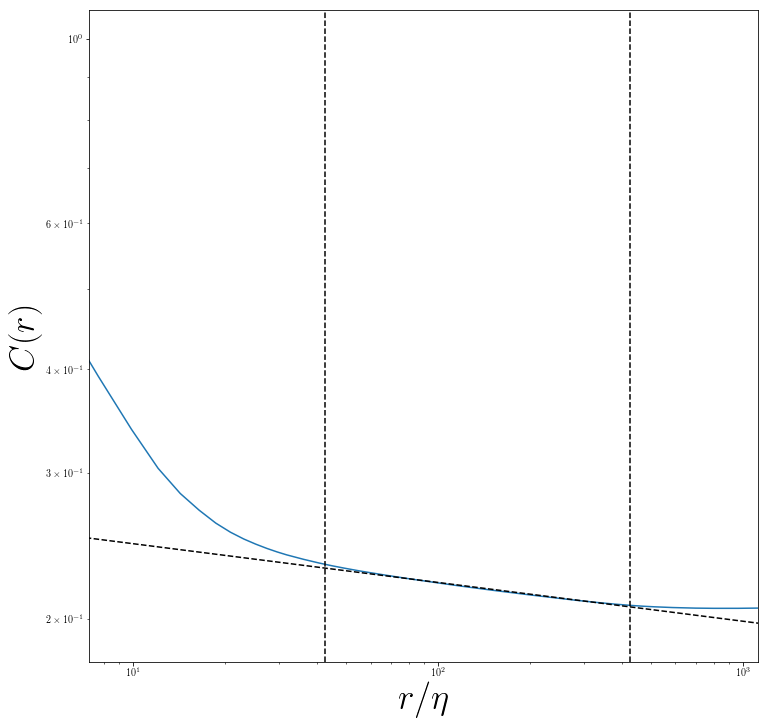

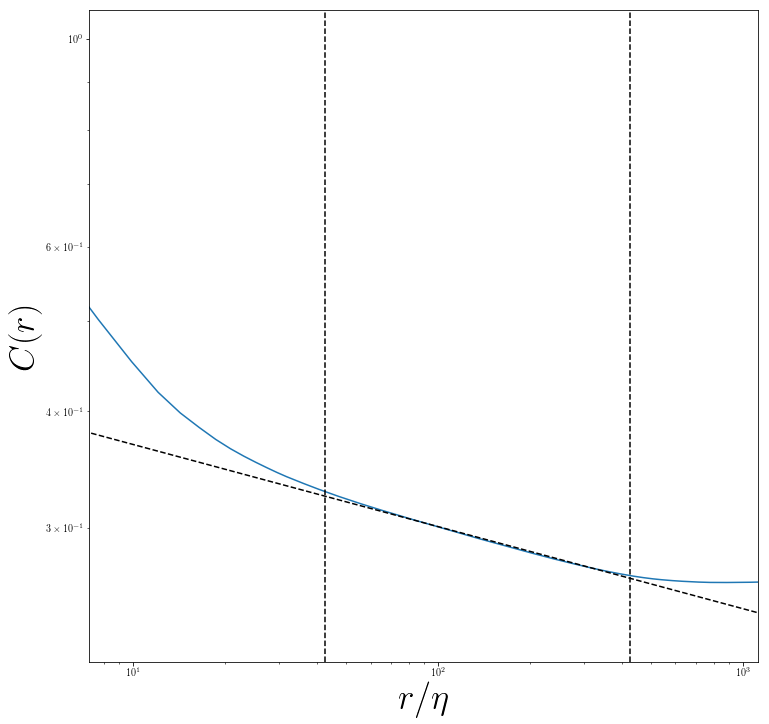

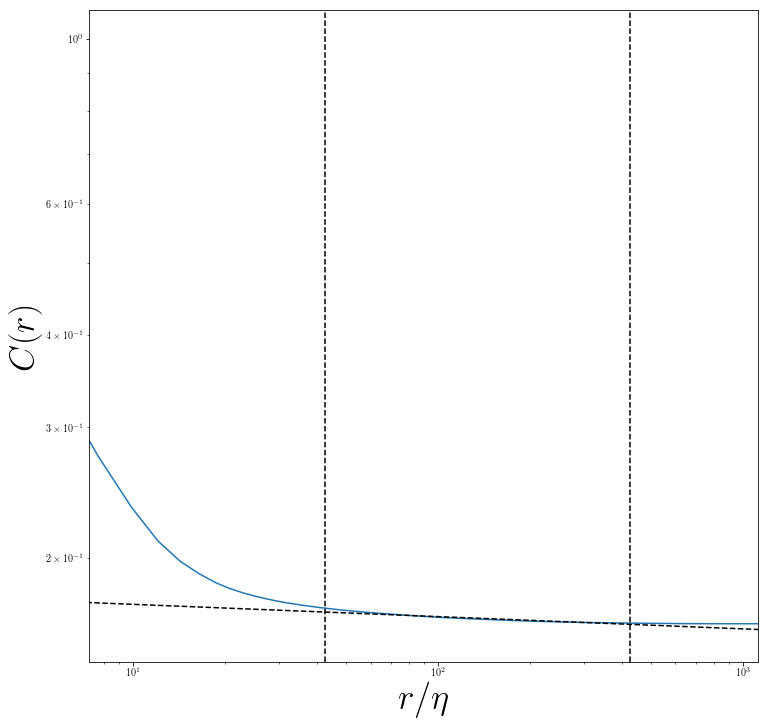

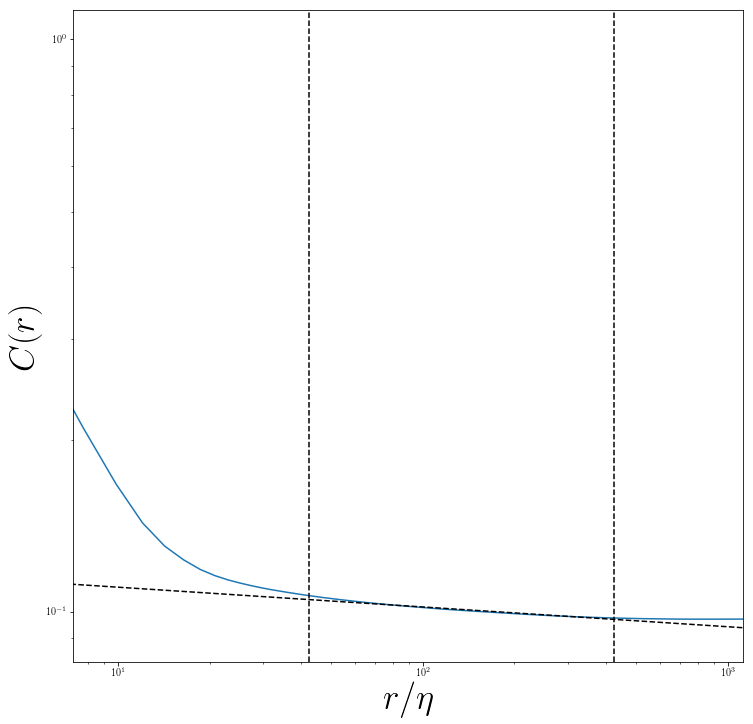

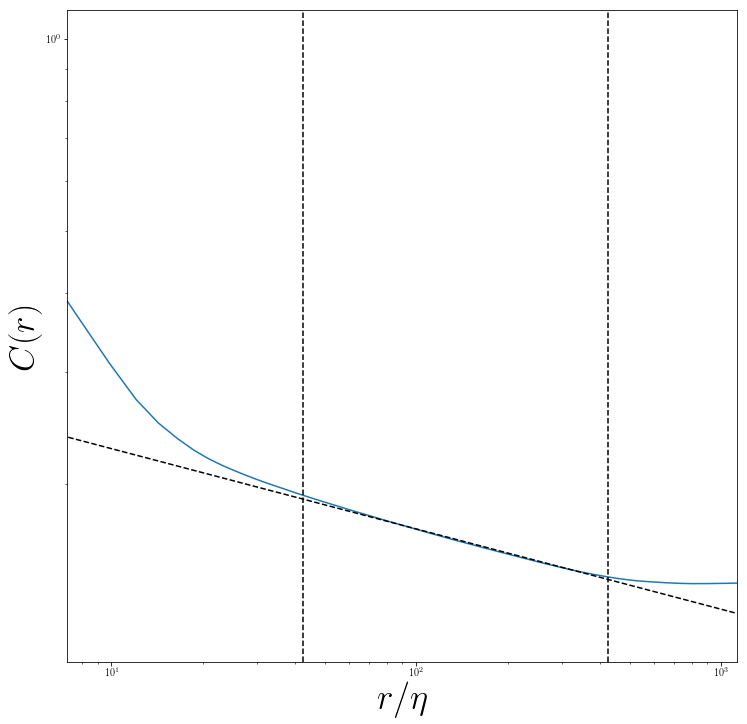

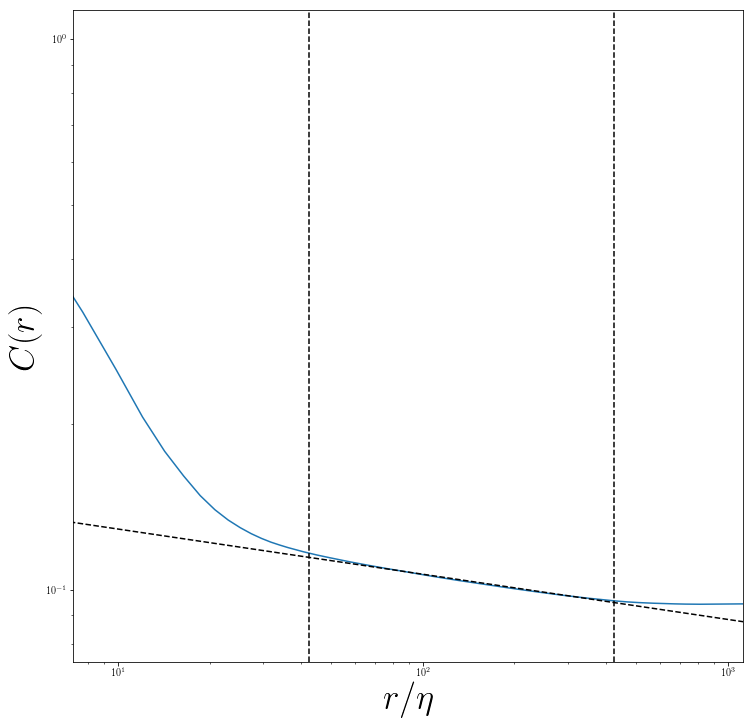

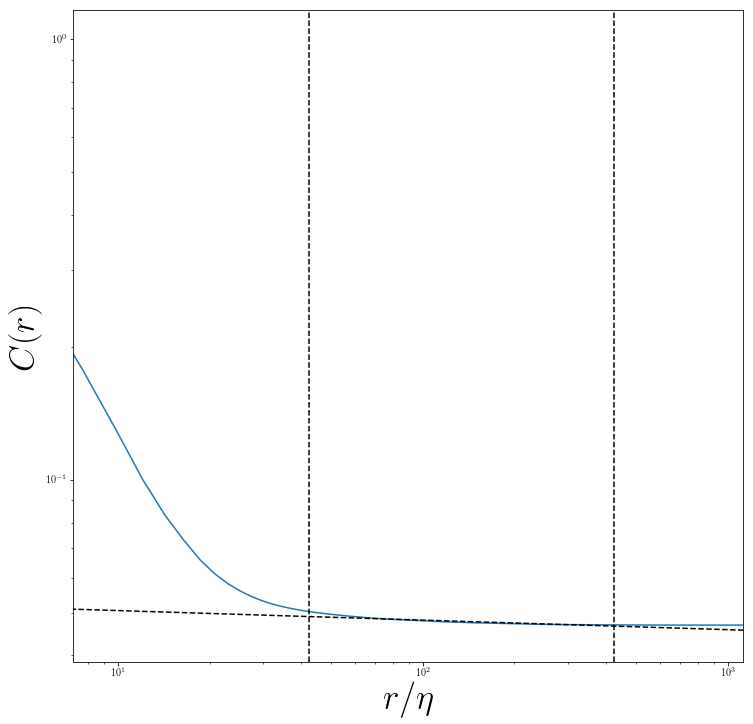

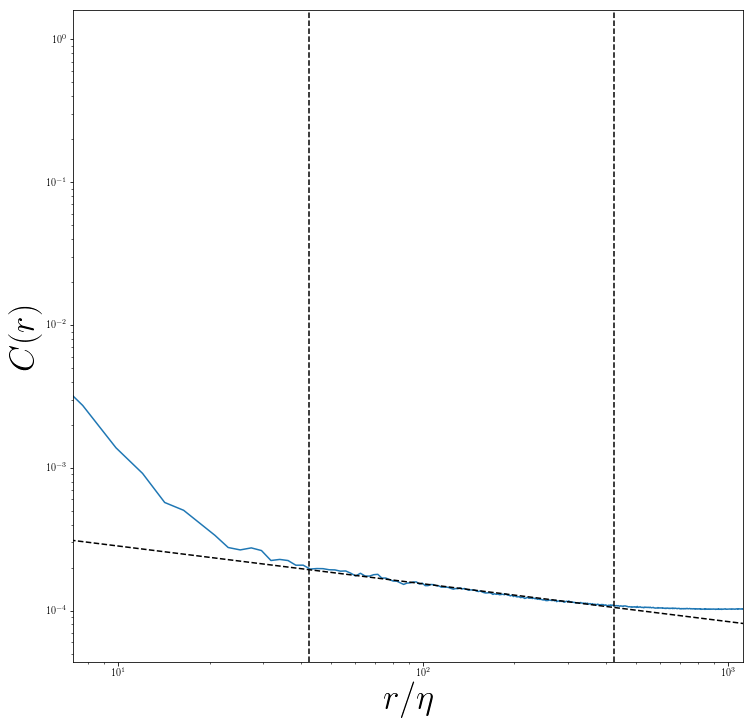

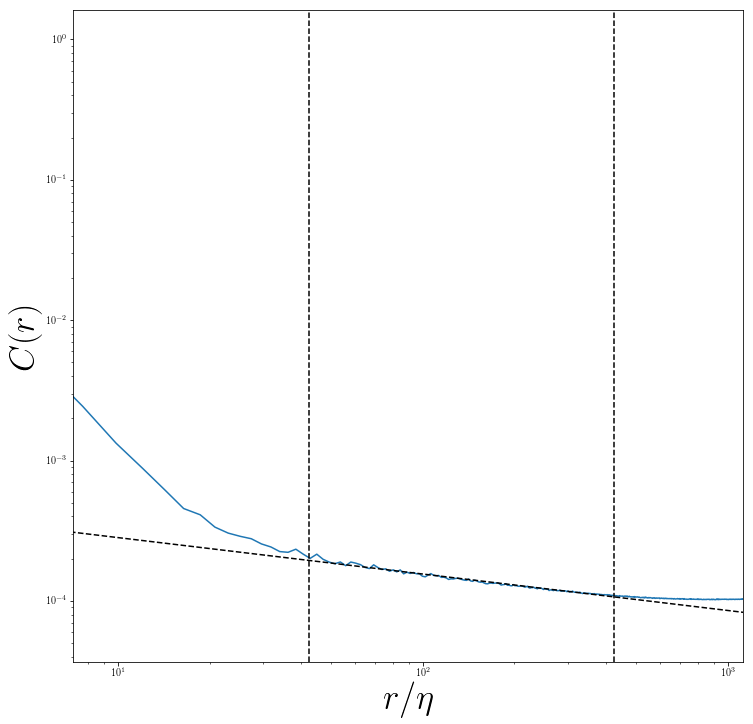

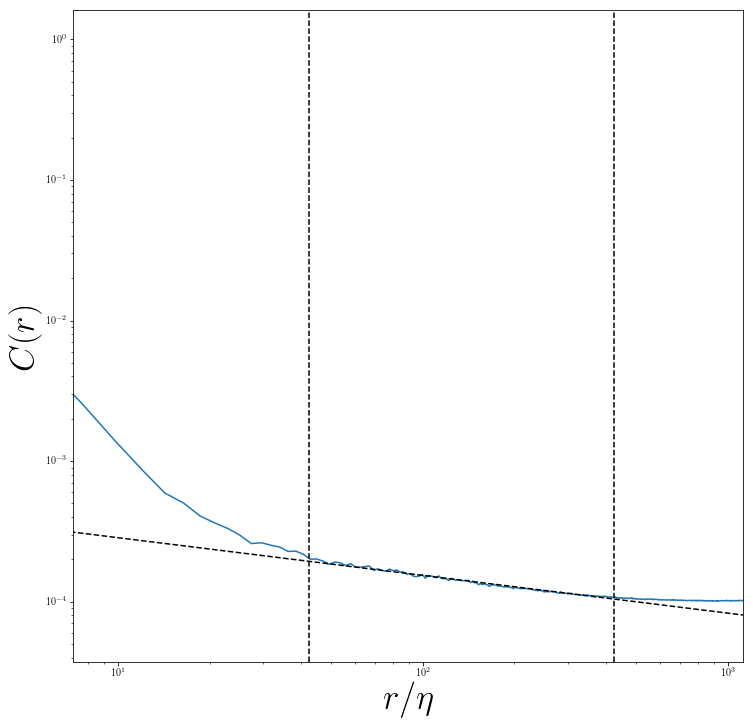

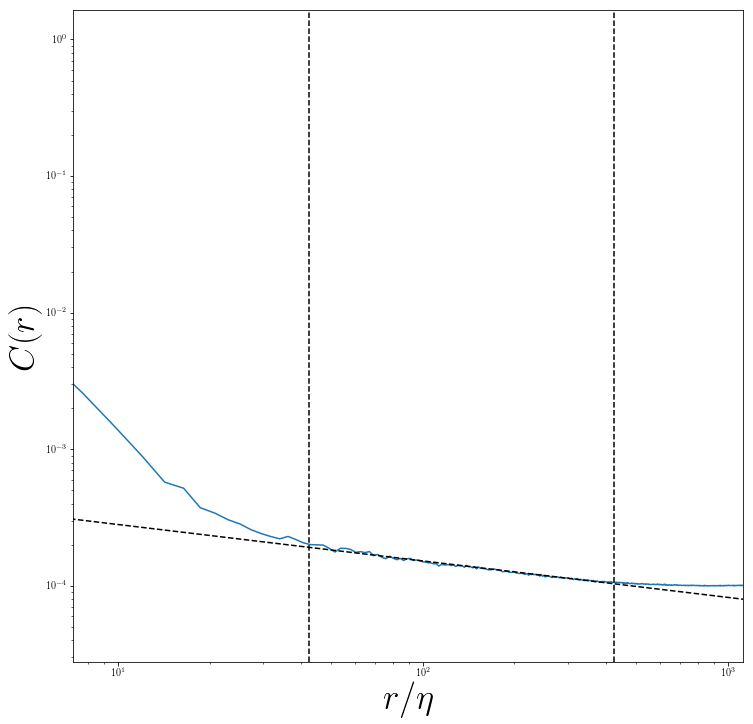

In [48]:
%%px

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('text', usetex=True)

if rank==0:
    eta = 0.00280
    
    rbins = np.linspace(minrt,maxrt,1+ner)    
    bins = (rbins[0:ner]+rbins[1:ner+1])/2
    tempRp = bins[(bins/eta>42.5)&(bins/eta<425)]/eta
    
    fiits = []    
    for i in range(E_bins-1):
        for j in range(E_bins-1):
            tQm = tl[i]; tQM = tl[i+1];            
            tRm = tl[j]; tRM = tl[j+1];
            
            plt.figure(figsize=(12,12))
            plt.xlabel(r'$r/\eta$', fontsize=35)
            plt.ylabel(r'$C(r)$', fontsize=35)
            plt.xlim([20*10**(-3)/eta,np.pi/eta])
            #plt.ylim([10**(-4),10**(0)])
            
            if(volFr[i*(E_bins-1)+j]>threshold):
                tcorr = lcorr[i*(E_bins-1)+j][llogr[i*(E_bins-1)+j]>0]
                tlogr = llogr[i*(E_bins-1)+j][llogr[i*(E_bins-1)+j]>0]
                tbins = bins[llogr[i*(E_bins-1)+j]>0]
                
                corrF = tcorr/tlogr
                tempCorrF = corrF[(tbins/eta>42.5)&(tbins/eta<425)]
                idx = (tempCorrF>0)
                
                if(len(tempCorrF[idx])>0):
                    fit = np.polyfit(np.log(tempRp[idx]),np.log(tempCorrF[idx]/corrF[0]),1)
                else:
                    fit = np.array([-4,0])
                    
                plt.loglog(bins/eta,corrF/corrF[0])
                plt.loglog(bins/eta,np.exp(fit[1])*((bins/eta)**(fit[0])),'k--')
            else:
                fit = np.array([-4,0])
                
            plt.axvline(x=42.50, color='k', linestyle='--')
            plt.axvline(x=425.0, color='k', linestyle='--')
            fiits.append(fit[0])
            print('t = ({one:.7f},{two:.7f})*sigma_2: Linear fit [alpha A] = {tree:.3f}'.format(one=(tQm+tQM)/2,two=(tRm+tRM)/2,tree=fit[0]+3))
            
    fiits = np.array(fiits)

In [ ]:
%%px

In [ ]:
%%px